In [1]:
import sys
import os
import pathlib
import numpy as np

# if __file__ is not defined, we are in a notebook
if '__file__' not in globals():
    __file__ = '04_model_performance.ipynb'
    
file_path = pathlib.Path(__file__).resolve()
parent_path = file_path.parent.parent
sys.path.append(str(parent_path))


In [2]:
# %%
import utils
import os
import pathlib
import argparse
from tensorboardX import SummaryWriter
import logging
from datetime import datetime
import torch 
import mymodels 
import mydataset 
from torch.utils.data import DataLoader
from utils.myfed import *
import yaml

/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed):
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
set_seed(0)

In [4]:
yamlfilepath = parent_path.joinpath('config.yaml')
args = yaml.load(yamlfilepath.open('r'), Loader=yaml.FullLoader)
args = argparse.Namespace(**args)
os.environ['CUDA_VISIBLE_DEVICES']=args.gpu

if args.dataset == 'cifar10':
    publicdata = 'cifar100'
    args.N_class = 10
elif args.dataset == 'cifar100':
    publicdata = 'imagenet'
    args.N_class = 100
elif args.dataset == 'pascal_voc2012':
    publicdata = 'mscoco'
    args.N_class = 20

assert args.dataset in ['cifar10', 'cifar100', 'pascal_voc2012']
args.datapath = os.path.expanduser(args.datapath)

In [5]:
priv_data, _, test_dataset, public_dataset, distill_loader = mydataset.data_cifar.dirichlet_datasplit(
    args, privtype=args.dataset, publictype=publicdata, N_parties=args.N_parties, online=not args.oneshot, public_percent=args.public_percent)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)

pascal_voc2012 mscoco
size of public dataset:  (32467, 3, 224, 224) images
size of test dataset:  (5823, 3, 224, 224) images
size of split_arr: (20, 5)
y label : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]
Party_0 data shape: (809, 3, 224, 224)
Party_1 data shape: (1011, 3, 224, 224)
Party_2 data shape: (1132, 3, 224, 224)
Party_3 data shape: (1162, 3, 224, 224)
Party_4 data shape: (1165, 3, 224, 224)
Public data shape: (32467, 3, 224, 224)
Test data shape: (5823, 3, 224, 224)


In [70]:
model = mymodels.define_model(modelname=args.model_name, num_classes=args.N_class, pretrained=args.pretrained)
load_model = torch.load('/home/suncheol/code/FedTest/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl+slNone/model-0.pth')
model.module.load_state_dict(load_model)

<All keys matched successfully>

In [71]:
from utils.calc import *

In [72]:
model.eval()
# testacc = utils.AverageMeter()
m = torch.nn.Sigmoid()
output_list = []
target_list = []

with torch.no_grad():
    for i, (images, target, _) in enumerate(test_loader):
        images = images.cuda()
        target = target.cuda()
        output = model(images)
        
        output_list.append(m(output).detach().cpu().numpy())
        target_list.append(target.detach().cpu().numpy())
        
        # testacc.update(acc)
output = np.concatenate(output_list, axis=0)
target = np.concatenate(target_list, axis=0)
acc, = utils.accuracy(output, target)


opt threshold = 0.2
accuracy = 0.4271480909038863
precision = 0.5193886312897132
recall = 0.5110080714408383
f1 score = 0.4857089701757385
optimal threshold = 0.2 best f1 score = 0.4271480909038863


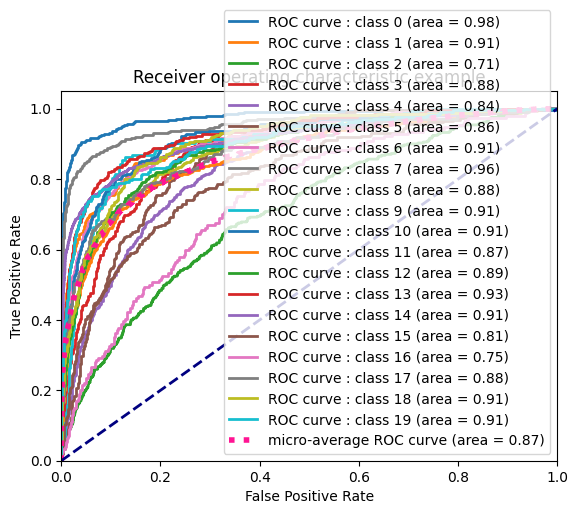

In [73]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

y_score = np.array(output) 
y_test = np.array(target)

th_ls = [0.1 * i for i in range(10)]
opt_th = 0
best_acc = 0
def get_metrics(y_test, y_score, th):
    y_pred = (y_score > th).astype(int)
    acc = getAccuracy(y_test, y_pred)
    pre = getPrecision(y_test, y_pred)
    rec = getRecall(y_test, y_pred)
    f1 = getF1score(y_test, y_pred)
    return acc, pre, rec, f1

for th in th_ls:
    acc, pre, rec, f1 = get_metrics(y_test, y_score, th)
    if acc > best_acc:
        best_acc = acc
        opt_th = th
        
acc, pre, rec, f1 = get_metrics(y_test, y_score, opt_th)
print("opt threshold = {}".format(opt_th))
print("accuracy = {}".format(acc))
print("precision = {}".format(pre))
print("recall = {}".format(rec))
print("f1 score = {}".format(f1))
print("optimal threshold = {}".format(opt_th), "best f1 score = {}".format(best_acc))

plotMultiROCCurve(y_test, y_score)



+---------------+---------------+-----------+
|               | not aeroplane | aeroplane |
+---------------+---------------+-----------+
| not aeroplane |      5478     |     2     |
|   aeroplane   |      166      |    177    |
+---------------+---------------+-----------+
+-------------+-------------+---------+
|             | not bicycle | bicycle |
+-------------+-------------+---------+
| not bicycle |     5524    |    15   |
|   bicycle   |     163     |   121   |
+-------------+-------------+---------+
+----------+----------+------+
|          | not bird | bird |
+----------+----------+------+
| not bird |   5274   | 179  |
|   bird   |   101    | 269  |
+----------+----------+------+
+----------+----------+------+
|          | not boat | boat |
+----------+----------+------+
| not boat |   5255   | 320  |
|   boat   |    24    | 224  |
+----------+----------+------+
+------------+------------+--------+
|            | not bottle | bottle |
+------------+------------+--------+


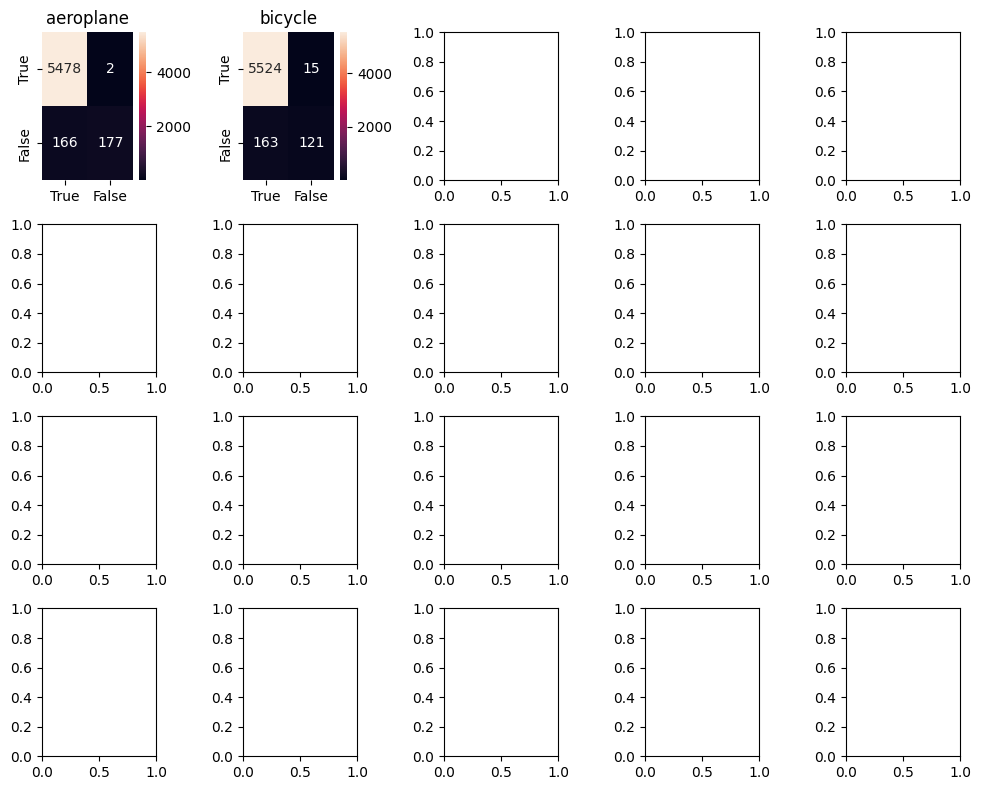

In [69]:
ml_cm = multi_label_confusion_matrix(y_test, y_score > opt_th, object_categories)
print(ml_cm)
plotMultilabelconfusionmatrix(y_test, y_score > opt_th, object_categories)


In [46]:
metrics.multilabel_confusion_matrix(y_test, y_score > opt_th)

array([[[4109, 1371],
        [   9,  334]],

       [[5530,    9],
        [ 218,   66]],

       [[5453,    0],
        [ 370,    0]],

       [[5465,  110],
        [ 178,   70]],

       [[5318,  164],
        [ 255,   86]],

       [[5615,    0],
        [ 208,    0]],

       [[5028,  224],
        [ 212,  359]],

       [[5045,  237],
        [  87,  454]],

       [[4904,  366],
        [ 214,  339]],

       [[5374,  297],
        [  65,   87]],

       [[5353,  201],
        [ 112,  157]],

       [[5120,   49],
        [ 464,  190]],

       [[5538,   40],
        [ 192,   53]],

       [[5536,   26],
        [ 186,   75]],

       [[3416,  314],
        [ 480, 1613]],

       [[5542,   23],
        [ 244,   14]],

       [[5669,    0],
        [ 154,    0]],

       [[5480,   93],
        [ 149,  101]],

       [[5546,    6],
        [ 250,   21]],

       [[5260,  278],
        [  79,  206]]])

aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


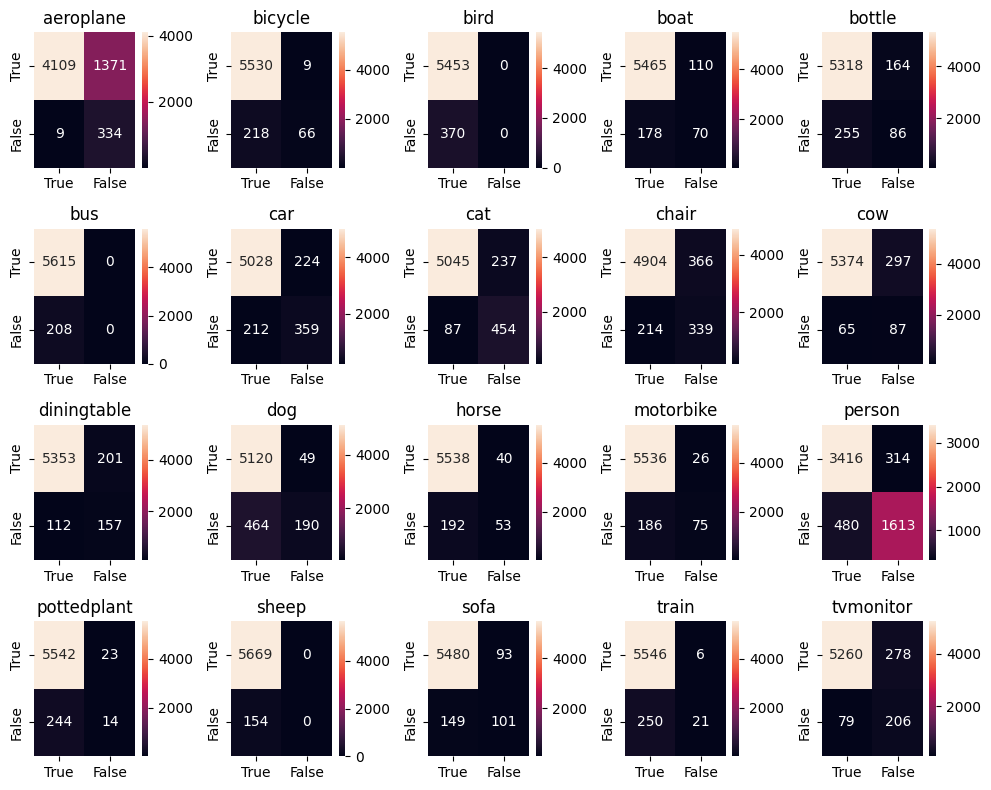

In [47]:
y_pred = (y_score > opt_th).astype(int)
y_test = y_test.astype(int)
labels = object_categories
cm = metrics.multilabel_confusion_matrix(y_test, y_pred)
''' plot n * 4 subplots '''
nClasses = len(labels)
fig, ax = plt.subplots(int(nClasses/5), 5, figsize=(10, 8))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print(label)
    df_cm = pd.DataFrame(cfs_matrix, index = [i for i in ["True", "False"]],
                columns = [i for i in ["True", "False"]])
    sns.heatmap(df_cm, annot=True, ax = axes, fmt='g')
    axes.set_title(label)
fig.tight_layout()
plt.show()